In [1]:
!python --version

Python 3.11.11


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

%matplotlib inline

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EPOCHS = 30
BS = 128
DROPOUT_RATE = 0.3
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
SGD_DECAY_STEPS = 25000

model = Sequential([
    Input(shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1"),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', padding='same', name="conv2"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool2"),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same', name="conv3"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool3"),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same', name="conv4"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool4"),
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation='relu', name='fc1'),
    Dropout(DROPOUT_RATE),
    BatchNormalization(),
    Dense(7, activation='softmax', name='fcsoftmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=SGD_LEARNING_RATE,
    decay_steps=SGD_DECAY_STEPS,
    decay_rate=SGD_DECAY
)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

cp_filepath = '/content/drive/My Drive/EC 523 Deep Learning/project/models/Baseline-weights-best.keras'
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [rlrop, checkpoint]


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/EC 523 Deep Learning/project/data/train.zip' -d train

In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/EC 523 Deep Learning/project/data/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/EC 523 Deep Learning/project/data/test-private.zip' -d test

In [ ]:
%%bash
root='/content/train/'
IFS=$'\n'
for dir in $(ls -1 "$root"); do
    printf "$dir: " && ls "$root/$dir" | wc -l
done

0 angry: 3995
1 disgust: 436
2 fear: 4097
3 happy: 7215
4 sad: 4830
5 surprise: 3171
6 neutral: 4965


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=dev_generator,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2284 - loss: 2.1889
Epoch 1: val_accuracy improved from -inf to 0.16996, saving model to /content/drive/My Drive/EC 523 Deep Learning/project/models/Baseline-weights-best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.2286 - loss: 2.1881 - val_accuracy: 0.1700 - val_loss: 2.0646 - learning_rate: 0.0092
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2990 - loss: 1.8012
Epoch 2: val_accuracy improved from 0.16996 to 0.27891, saving model to /content/drive/My Drive/EC 523 Deep Learning/project/models/Baseline-weights-best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.2990 - loss: 1.8011 - val_accuracy: 0.2789 - val_loss: 2.0882 - learning_rate: 0.0085
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3402 - loss: 1.7084
Epoch 3: val_accuracy improved from 0.27891 to 0.39315, saving model to /content/drive/My Drive/EC 523 Deep Learning/project/models/Baseline-wei

In [ ]:
 print('\n# Evaluate on dev data')
results_dev = model.evaluate(dev_generator, steps=3589 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.3889 - loss: 1.6000
dev loss, dev acc: [1.6062757968902588, 0.3875558078289032]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator, steps=3589 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.3853 - loss: 1.6072
test loss, test acc: [1.606035828590393, 0.3816964328289032]


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


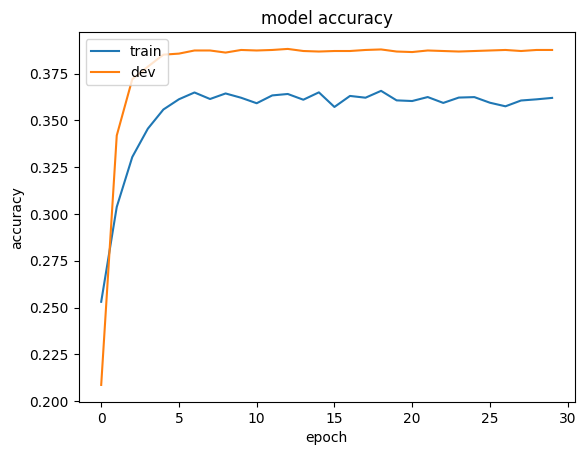

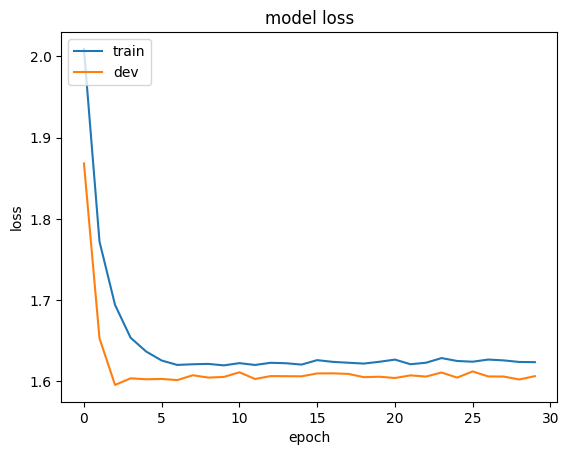

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/EC 523 Deep Learning/project/models/' + 'SOA' + epoch_str + dropout_str + test_acc + '.h5')

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step


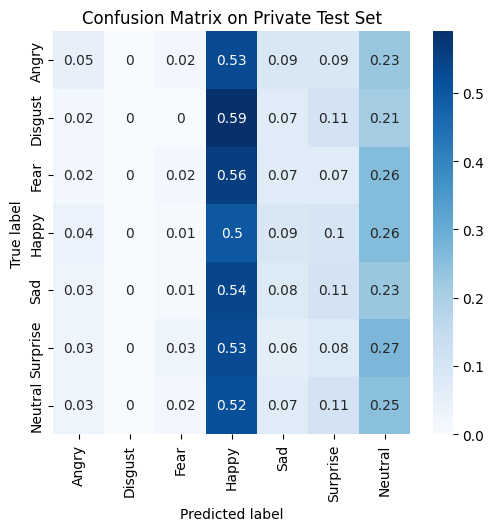

In [ ]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict(dev_generator).argmax(axis=1)
y_true = dev_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(),
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)

 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [ ]:
print('\n# Evaluate on test data')
TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)


# Evaluate on test data


NameError: name 'X_test' is not defined